In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split


In [28]:
import math
import pprint
import random
from typing import Dict, List, Optional, Set, Tuple, Union

pp = pprint.PrettyPrinter(indent=4)


# Reading data

In [29]:
def next_n(generator, n: int) -> List[int]:
    return [int(next(generator)) for _ in range(n)]

def read_data(file_name: str) -> List[Tuple[List[int], List[int], List[int]]]:
    sequences = list()
    with open(file_name, "r") as f:
        for line in f:
            values = iter(line.split())
            n_notes = int(next(values))
            sequences.append((next_n(values, n_notes), next_n(values, n_notes - 1), next_n(values, n_notes)))
    return sequences


In [30]:
sequences = read_data("../data/note_sequences.txt")


# Preparing data

In [5]:
sequences_df = pd.DataFrame(sequences)
sequences_df.head(5)


,0,1,2
0,"[9, 6, 9, 4, 7]","[-3, 3, -5, 3]","[4, 2, 3, 2, 3]"
1,"[8, 3, 11, 5, 7]","[-5, -4, 6, 2]","[4, 2, 1, 2, 3]"
2,"[10, 11, 0, 4, 8]","[1, 1, 4, 4]","[3, 4, 1, 2, 4]"
3,"[2, 1, 7, 0, 6]","[-1, -6, 5, 6]","[3, 2, 1, 2, 4]"
4,"[0, 2, 2, 2, 6]","[2, 12, -12, 4]","[4, 1, 5, 1, 2]"


In [6]:
CYCLE_LENGTH = 12

def create_positions_tensor(positions_list: List[List[int]]) -> torch.Tensor:
    positions = np.array(positions_list)[:,[0, 1, 3, 4, 2]]
    positions = (2 * math.pi / CYCLE_LENGTH) * np.expand_dims(positions, axis=2)
    positions_sin, positions_cos = np.sin(np.copy(positions)), np.cos(np.copy(positions))
    return torch.from_numpy(np.concatenate((positions_sin, positions_cos), axis=2)).float()


In [7]:
MAGNITUDE_SCALE = 12

def create_intervals_tensor(intervals_list: List[List[int]]) -> torch.Tensor:
    # Pad on the left side (set first value to 0 for all sequences)
    intervals = np.pad(np.array(intervals_list), [(0, 0), (1, 0)])
    intervals = intervals[:, [0, 1, 3, 4, 2]]
    intervals = np.expand_dims(intervals, axis=2)
    intervals_sign, intervals_mag = np.copy(intervals) > 0, np.abs(np.copy(intervals)) / MAGNITUDE_SCALE
    return torch.from_numpy(np.concatenate((intervals_sign, intervals_mag), axis=2)).float()


In [8]:
def create_fingerings_one_hot_tensor(fingerings_list: List[List[int]]) -> torch.Tensor:
    fingerings = np.array(fingerings_list)
    fingerings = np.pad(fingerings[:,:-1], [(0, 0), (1, 0)])[:, [0, 1, 0, 0, 2]]
    fingerings_one_hot_tensor = torch.tensor(fingerings)
    return nn.functional.one_hot(fingerings_one_hot_tensor, num_classes=6)


In [9]:
def create_fingerings_tensor(fingerings_list: List[List[int]]) -> torch.Tensor:
    fingerings = np.array(fingerings_list)[:, [0, 1, 3, 4, 2]]
    return torch.LongTensor(np.expand_dims(fingerings, axis=2))


In [10]:
positions_tensor = create_positions_tensor(sequences_df[0].to_list())
intervals_tensor = create_intervals_tensor(sequences_df[1].to_list())
fingerings_one_hot_tensor = create_fingerings_one_hot_tensor(sequences_df[2].to_list())

inputs_tensor = torch.cat((positions_tensor, intervals_tensor, fingerings_one_hot_tensor), dim=2)
outputs_tensor = create_fingerings_tensor(sequences_df[2].to_list())

inputs_tensor[:1]


tensor([[[-1.0000e+00, -1.8370e-16,  0.0000e+00,  0.0000e+00,  1.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 1.2246e-16, -1.0000e+00,  0.0000e+00,  2.5000e-01,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00],
         [ 8.6603e-01, -5.0000e-01,  0.0000e+00,  4.1667e-01,  1.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-5.0000e-01, -8.6603e-01,  1.0000e+00,  2.5000e-01,  1.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-1.0000e+00, -1.8370e-16,  1.0000e+00,  2.5000e-01,  0.0000e+00,
           0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]]])

In [11]:
train_inputs, test_inputs, train_outputs, test_outputs = train_test_split(inputs_tensor, outputs_tensor, test_size=0.2)


# Creating RNN model

In [12]:
class Model1(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model1, self).__init__()
        self.hidden_size = hidden_size

        combined_size = input_size + hidden_size
        self.i2h = nn.Linear(combined_size, hidden_size)
        self.i2o = nn.Linear(combined_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        input_combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)


# Training RNN model

In [13]:
rnn = Model1(10, 64, 6)
criterion = nn.NLLLoss()
learning_rate = 0.0005
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)


def train(input_tensor: torch.Tensor, output_tensor: torch.Tensor) -> Tuple[torch.Tensor, float]:
    hidden = rnn.init_hidden()
    optimizer.zero_grad()
    loss = torch.Tensor([0])

    for i in range(len(input_tensor)):
        output, hidden = rnn(input_tensor[i], hidden)
        loss += criterion(output, output_tensor[i])

    loss.backward()
    optimizer.step()

    return output, loss.item() / input_tensor.size(0)


In [22]:
import time

n_iters = len(train_inputs)
print_every = int(n_iters // 20)
plot_every = int(n_iters // 100)
all_losses = []
total_loss = 0

rnn.train()

start = time.time()

for iteration in range(1, n_iters + 1):
    i = random.randint(0, len(train_inputs) - 1)
    input_tensor, output_tensor = train_inputs[i], train_outputs[i]
    output, loss = train(input_tensor.unsqueeze(1), output_tensor)
    total_loss += loss

    if iteration % print_every == 0:
        print(f"{round(time.time() - start, 2)} ({iteration} {(iteration * 100) // n_iters}%) {round(loss, 4)}")

    if iteration % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0


16.13 (24000 5%) 1.2677
31.95 (48000 10%) 1.6145
48.08 (72000 15%) 1.0496
63.48 (96000 20%) 1.2494
78.7 (120000 25%) 1.6884
94.76 (144000 30%) 1.3961
109.93 (168000 35%) 1.5274
125.15 (192000 40%) 1.3442
140.27 (216000 45%) 1.2388
155.7 (240000 50%) 1.4075
171.02 (264000 55%) 1.2321
186.4 (288000 60%) 1.2409
202.43 (312000 65%) 1.0522
217.94 (336000 70%) 1.3869
233.13 (360000 75%) 1.1735
248.66 (384000 80%) 1.2275
263.88 (408000 85%) 1.3605
279.23 (432000 90%) 1.2547
294.64 (456000 95%) 1.6268
310.19 (480000 100%) 1.1087


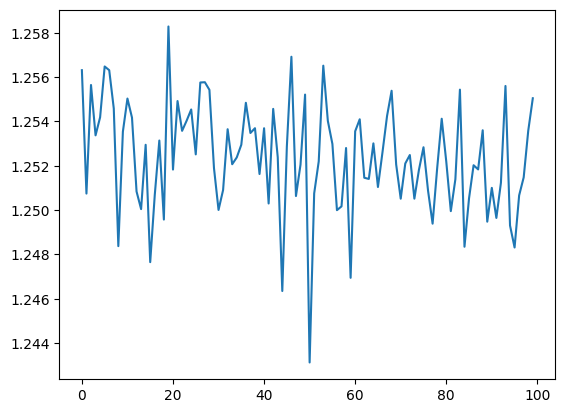

In [23]:
plt.figure()
plt.plot(all_losses)
plt.show()


# Testing RNN model

In [24]:
def validate(rnn: nn.Module) -> float:
    rnn.eval()
    count = 0

    with torch.no_grad():
        for i in range(len(test_inputs)):
            input_tensor, output_tensor = test_inputs[i].unsqueeze(1), test_outputs[i]
            hidden = rnn.init_hidden()

            for j in range(len(input_tensor)):
                output, hidden = rnn(input_tensor[j], hidden)

            _, top_i = output.topk(1)
            count += (output_tensor[-1][0].item() == top_i[0][0].item())

    return count / len(test_inputs)


In [25]:
validate(rnn)


0.5150166666666667

# Running on sample data

In [18]:
def evaluate_continuous(rnn: nn.Module, positions: torch.Tensor, intervals: torch.Tensor, fingerings: torch.Tensor, window_size: int = 5):
    fingerings = fingerings[:window_size]
    rnn.eval()

    with torch.no_grad():
        for i in range(len(positions) - window_size + 1):
            position_tensor = create_positions_tensor([positions[i: i + window_size]])
            interval_tensor = create_intervals_tensor([intervals[i: i + window_size - 1]])
        
            fingering_one_hot_tensor = create_fingerings_one_hot_tensor([fingerings[i: i + window_size]])

            input_tensor = torch.cat((position_tensor, interval_tensor, fingering_one_hot_tensor), dim=2)[0].unsqueeze(1)
            hidden = rnn.init_hidden()

            for j in range(window_size):
                output, hidden = rnn(input_tensor[j], hidden)

            _, top_i = output.topk(1)
            fingerings[-3] = top_i[0][0].item()
            fingerings.append(0)

    return fingerings[:-1]


In [27]:
DATA_1 = (
    [8, 0, 2, 3, 5, 2, 7, 10, 0, 2, 3, 0, 5, 7, 8, 10, 0, 8],
    [-8, 2, 1, 2, -3, 5, -9, 2, 2, 1, -3, 5, -10, 1, 2, 2, -4],
    [5, 1, 2, 0, 0],
)
DATA_2 = (
    [6, 0, 11, 2, 5, 3, 6, 7, 11, 8, 0, 2, 5, 3, 6, 7, 11],
    [6, -1, 3, 3, -2, 3, 1, 4, -3, 4, 2, 3, -2, 3, 2, 4],
    [1, 3, 2, 0, 0],
)

evaluate_continuous(rnn, *DATA_2)


[1, 3, 2, 3, 2, 1, 2, 3, 2, 1, 2, 3, 2, 1, 2, 0, 0]

In [176]:
torch.save(rnn.state_dict(), "model_rnn.pt")
